# Degrees of Change map

These maps display the projected differences in maximum temperature between a baseline time period (1961-1990) and end of century (2070-2099) period.

In [31]:
# A 'magic' command that displays plots inline inside the notebook as static images
%matplotlib inline

import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import gdal
from mpl_toolkits.basemap import Basemap
from PIL import Image
from io import BytesIO

# entry point of the API
api = 'http://api.cal-adapt.org/api'

### Let's look at data for Sacramento County

If you open [this link](http://api.cal-adapt.org/api/), you can see a list of resources currently available through the api. The list of climate datasets is under `series`. You can pass in your own geometry to query the climate data or use geometry available through the api. For this exercise we will use the `counties` resource available through the Cal-Adapt api. 

The code below gets the `id` for the polygon feature (Sacramento County) by querying the `counties` resource.

In [6]:
feature_resource = 'counties'
feature = None

# Point location (within Sacramento County) in geojson format
lat = 38.5938
lng = -121.4687
point = '{"type":"Point","coordinates":[' + str(lng) + ',' + str(lat) + ']}'

# Params
params = {'intersects': point, 'srs': 4326, 'precision': 4}
params_str = "&".join("%s=%s" % (k,v) for k,v in params.items())

# Construct url
url = api + '/' + feature_resource + '/' + '?' + params_str
print(url)

# Get county geometry from api
# Construct a uri string which we will pass to the api later
try:
    response = requests.get(url, headers=headers)
    json = response.json()
    feature = json['features'][0]
except requests.exceptions.HTTPError as err:
    print (err)

http://api.cal-adapt.org/api/counties/?intersects={"type":"Point","coordinates":[-121.4687,38.5938]}&srs=4326&precision=4


### Get Maximum Temperature for HadGEM2-ES model for both RCP4.5 and RCP 8.5 scenarios

Url's for resources are hardcoded below, if you want to explore how to get other climate data check out these [Jupyter Notebooks](https://github.com/berkeley-gif/caladapt-public)

In [37]:
# Period
startYear = 1961
endYear = 1963

# Query parameters dict
params = {
    'pagesize': 100,
    'ref': '/api/' + feature_resource + '/' + str(feature['id']) + '/',
}

url = 'http://api.cal-adapt.org/api/series/tasmax_year_HadGEM2-ES_historical/' + str(startYear) + '-01-01/' + str(endYear) + '-12-31/'

# Make request
response = requests.get(url)

array_list = []

if response.ok:
    data = response.json()
    # Get a list of Raster Stores
    results = data['results']
    nodata = results[0]['nodata']
    #rasterArray = np.ma.masked_equal(data, nodata)
    # Iterate through the list and print the event and image property of each Raster Store
    for item in results:
        im = Image.open(requests.get(item['image'], stream=True).raw)
        # Creates a numpy array from image 
        data = np.array(im)
        # Any calculations will be wrong if nodata values are not taken care of
        # Create a masked array for making calculations without nodata values
        rasterArray = np.ma.masked_equal(data, nodata)
        array_list.append(rasterArray)

[masked_array(data =
  [[-- -- -- ..., 283.90924072265625 282.8677978515625 285.150146484375]
  [-- -- -- ..., 283.6562194824219 285.348876953125 286.0563659667969]
  [-- -- -- ..., 284.540283203125 286.1128845214844 286.41070556640625]
  ..., 
  [-- -- -- ..., 301.7541809082031 301.53350830078125 303.1330871582031]
  [-- -- -- ..., 302.6947937011719 302.7872314453125 303.4317626953125]
  [-- -- -- ..., 302.7048645019531 302.9548645019531 303.3791198730469]],
              mask =
  [[ True  True  True ..., False False False]
  [ True  True  True ..., False False False]
  [ True  True  True ..., False False False]
  ..., 
  [ True  True  True ..., False False False]
  [ True  True  True ..., False False False]
  [ True  True  True ..., False False False]],
        fill_value = 1e+30), masked_array(data =
  [[-- -- -- ..., 283.8445129394531 282.8127136230469 285.1479187011719]
  [-- -- -- ..., 283.6246032714844 285.3237609863281 286.0760803222656]
  [-- -- -- ..., 284.5011901855469 286.0

### Define function for processing each geotiff file

Function `read_file` takes a text string representing path to a geotiff file and returns a masked numpy array.

In [5]:
def read_file(file):
    ds = gdal.Open(file)
    band = ds.GetRasterBand(1)
    # Get nodata value from the GDAL band object
    nodata = band.GetNoDataValue()
    # Creates a numpy array that contains the original nodata values. 
    data = band.ReadAsArray()
    # Any calculations will be wrong if nodata values are not taken care of
    # Create a masked array for making calculations without nodata values
    rasterArray = np.ma.masked_equal(data, nodata)
    band = None
    ds = None
    return rasterArray

### Calculate baseline average (1961-1990) using observed historical

In [6]:
# Make a list of files for observed historical
file_list = glob(os.path.join(data_dir, 'livneh', '*.tif'))
# Read all geotiff files as a list of numpy arrays 
array_list = [read_file(x) for x in file_list]

In [7]:
# Perform averaging
hist_observed_1961_1990 = np.ma.array(tuple(array_list)).mean(axis=0)
print(hist_observed_1961_1990.min(), hist_observed_1961_1990.max(), type(hist_observed_1961_1990))
file_list = None
array_list = None

3.51469150666 32.4824297505 <class 'numpy.ma.core.MaskedArray'>


### Calculate baseline average (1961-1990) using modeled historical

In [8]:
# Make a list of files for observed historical
file_list = glob(os.path.join(data_dir, 'HadGEM2-ES_historical', '*.tif'))
# Read all geotiff files as a list of numpy arrays 
array_list = [read_file(x) for x in file_list]
# Perform averaging
hist_modeled_1961_1990 = np.ma.array(tuple(array_list)).mean(axis=0)
# Convert Kelvin to Degrees Celsius
hist_modeled_1961_1990 = hist_modeled_1961_1990 - 273.15
print(hist_modeled_1961_1990.min(), hist_modeled_1961_1990.max())
file_list = None
array_list = None

3.60989163306 32.3798639113


### Calculate future average (2070-2099) using modeled projections for RCP4.5 and RCP8.5

In [9]:
# Make a list of files for observed historical
file_list = glob(os.path.join(data_dir, 'HadGEM2-ES_rcp45', '*.tif'))
# Read all geotiff files as a list of numpy arrays 
array_list = [read_file(x) for x in file_list]
# Perform averaging
rcp45_modeled_2070_2099 = np.ma.array(tuple(array_list)).mean(axis=0)
# Convert Kelvin to Degrees Celsius
rcp45_modeled_2070_2099 = rcp45_modeled_2070_2099 - 273.15
print(rcp45_modeled_2070_2099.min(), rcp45_modeled_2070_2099.max())
file_list = None
array_list = None

7.70198567708 36.2791015625


In [10]:
# Make a list of files for observed historical
file_list = glob(os.path.join(data_dir, 'HadGEM2-ES_rcp85', '*.tif'))
# Read all geotiff files as a list of numpy arrays 
array_list = [read_file(x) for x in file_list]
# Perform averaging
rcp85_modeled_2070_2099 = np.ma.array(tuple(array_list)).mean(axis=0)
# Convert Kelvin to Degrees Celsius
rcp85_modeled_2070_2099 = rcp85_modeled_2070_2099 - 273.15
print(rcp85_modeled_2070_2099.min(), rcp85_modeled_2070_2099.max())
file_list = None
array_list = None

9.96204427083 38.4527018229


### Export to geotiff

If you want to save the decadal averages out to a new geotiff file, you could use the following code. Repeat for all the new arrays. 

In [11]:
# Get metadata from one of the input files
inFileName = glob(os.path.join(data_dir, 'HadGEM2-ES_rcp85', '*.tif'))[0]
ds = gdal.Open(inFileName)

gt = ds.GetGeoTransform()   
proj = ds.GetProjection()

xres = gt[1]
yres = gt[5]

rows = ds.RasterXSize
cols = ds.RasterYSize

xmin = gt[0] + xres * 0.5
xmax = gt[0] + (xres * rows) - xres * 0.5
ymin = gt[3] + (yres * cols) + yres * 0.5
ymax = gt[3] - yres * 0.5

outFileName = os.path.join(data_dir, 'rcp85_modeled_2070_2099.tif')

driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, rows, cols, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(ds.GetGeoTransform()) # sets same geotransform as input
outdata.SetProjection(ds.GetProjection()) # sets same projection as input
outdata.GetRasterBand(1).WriteArray(rcp85_modeled_2070_2099)
outdata.FlushCache() # saves to disk!!
outdata = None
ds = None

In [12]:
#data = read_file(outFileName)
# fig, ax = plt.subplots(1, 1)
# img = plt.imshow(data, extent=[xmin, xmax, ymin, ymax], cmap='hot')
# fig.colorbar(img)
# plt.show()

In [13]:
#data = np.flipud(data)

### Calculate degrees of change

In [14]:
#rcp45 = rcp45_modeled_2070_2099 - hist_observed_1961_1990
rcp45 = rcp45_modeled_2070_2099 - hist_modeled_1961_1990
rcp45.min(), rcp45.max()

(2.0609889532930197, 5.0766979586693424)

In [15]:
#rcp85 = rcp85_modeled_2070_2099 - hist_observed_1961_1990
rcp85 = rcp85_modeled_2070_2099 - hist_modeled_1961_1990
rcp85.min(), rcp85.max()

(3.778957703293031, 7.9547641549058881)

### Plot degrees of change maps

Create a list of values for binning the data

In [16]:
data_bins = [x*1.0 for x in range(10)]
data_bins

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

Define a function that takes two arguments - (1) axes to plot figure on, (2) data array and returns a map

In [17]:
# Projection used in California Albers (EPSG 3310)
def setup_map(ax, data):
    m = Basemap(resolution = 'l',
              epsg = '3310',
              llcrnrlon = xmin, urcrnrlon = xmax,
              llcrnrlat = ymin, urcrnrlat = ymax,
              ax = ax
             )
    x = np.linspace(0, m.urcrnrx, data.shape[1])
    y = np.linspace(0, m.urcrnry, data.shape[0])
    xx, yy = np.meshgrid(x, y)
    cs = m.contourf(xx, yy, np.flipud(data), tuple(data_bins))
    cbar = m.colorbar(cs ,location='bottom', pad="5%")
    cbar.set_label('C')
    return m

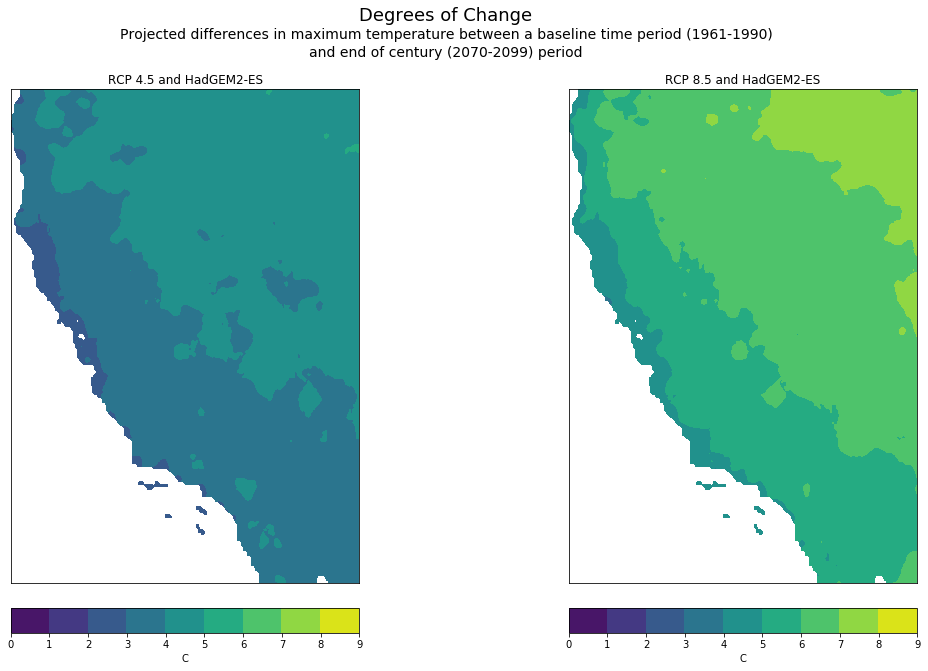

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].set_title('RCP 4.5 and HadGEM2-ES')
map1 = setup_map(ax[0], rcp45)

ax[1].set_title('RCP 8.5 and HadGEM2-ES')
map2 = setup_map(ax[1], rcp85)

plt.subplots_adjust(wspace=0, hspace=0)
plt.gcf().text(0.5, 0.975, 'Degrees of Change', fontsize=18, ha='center')
desc_str1 = 'Projected differences in maximum temperature between a baseline time period (1961-1990)'
desc_str2 = 'and end of century (2070-2099) period';
plt.gcf().text(0.5, 0.95, desc_str1, fontsize=14, ha='center')
plt.gcf().text(0.5, 0.925, desc_str2, fontsize=14, ha='center')
plt.show()